In [1]:
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
os.chdir("drive/Mydrive/componentDetect_test")

In [10]:
import matplotlib
matplotlib.use("Agg")

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
import numpy as np
import seaborn as sns
import os
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

In [11]:
# Load the base model
model = load_model("cnn-rico-1.h5")

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 65536)             0         
                                                                 
 dense_1 (Dense)             (None, 128)               8388736   
                                                      

In [13]:
CLASSES = 14
HEIGHT = 64
WIDTH = 64
CHANNELS = 3

In [17]:
for i in range(5):
    model.layers[i].trainable = False

ll = model.layers[4].output
ll = Dense(128, activation="relu")(ll)
ll = Dropout(0.2)(ll)
ll = Dense(64, activation="relu")(ll)
ll = Dropout(0.2)(ll)
ll = Dense(CLASSES, activation="softmax")(ll)

In [18]:
new_model = Model(inputs=model.input,outputs=ll)

In [19]:
new_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1_input (InputLayer)  [(None, 64, 64, 3)]      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 65536)             0         
                                                           

In [20]:
# Image preprocessing for robustness
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=(0.9,1),
    height_shift_range=(-0.05, 0.05),
    width_shift_range=(-0.05, 0.05),
)

In [21]:
BATCH_SIZE = 10

print("[INFO] loading images...")
train_data_dir = "./dataset/snipped"     # directory of training data

training_set = train_datagen.flow_from_directory(train_data_dir, 
                                                 target_size=(WIDTH, HEIGHT),
                                                 batch_size=BATCH_SIZE, 
                                                 class_mode='categorical')

[INFO] loading images...
Found 463 images belonging to 14 classes.


In [22]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_data_dir = "./dataset/snipped"       # directory of test data
test_set = test_datagen.flow_from_directory(test_data_dir, 
                                            target_size=(WIDTH, HEIGHT),
                                            batch_size=BATCH_SIZE, 
                                            class_mode='categorical',
                                            shuffle=False)

Found 463 images belonging to 14 classes.


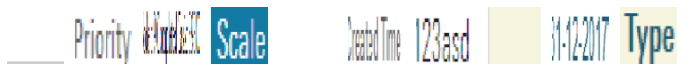

In [23]:
# Plot some images form the augmented results

x_batch, y_batch = next(training_set)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    # img = (img - np.min(img))/(np.max(img) - np.min(img))
    plt.subplot(5, 10, k+1)
    # im = Image.open(img).convert('RGB')
    plt.imshow(np.asarray(img)[:, :, ])
    plt.axis('off')

In [24]:
new_model.compile(
    loss="categorical_crossentropy", 
    optimizer = Adam(lr=0.001), 
    metrics=["accuracy"]
)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [25]:
print("[INFO] training model...")

EPOCHS = 25

history = new_model.fit(
    training_set,
    epochs=EPOCHS,
    steps_per_epoch=training_set.samples//BATCH_SIZE,
    validation_data=test_set,
    validation_steps=test_set.samples//BATCH_SIZE
)

[INFO] training model...
Epoch 1/25
46/46 [==============================] - 73s 2s/step - loss: 0.8441 - accuracy: 0.8212 - val_loss: 0.2939 - val_accuracy: 0.9174
Epoch 2/25
46/46 [==============================] - 11s 240ms/step - loss: 0.3135 - accuracy: 0.9205 - val_loss: 0.2371 - val_accuracy: 0.9435
Epoch 3/25
46/46 [==============================] - 13s 284ms/step - loss: 0.1897 - accuracy: 0.9669 - val_loss: 0.1895 - val_accuracy: 0.9543
Epoch 4/25
46/46 [==============================] - 12s 248ms/step - loss: 0.1652 - accuracy: 0.9514 - val_loss: 0.1830 - val_accuracy: 0.9413
Epoch 5/25
46/46 [==============================] - 16s 355ms/step - loss: 0.0915 - accuracy: 0.9757 - val_loss: 0.1505 - val_accuracy: 0.9587
Epoch 6/25
46/46 [==============================] - 13s 287ms/step - loss: 0.1034 - accuracy: 0.9757 - val_loss: 0.1154 - val_accuracy: 0.9652
Epoch 7/25
46/46 [==============================] - 11s 248ms/step - loss: 0.0787 - accuracy: 0.9779 - val_loss: 0.1341 

In [26]:
# Save the model
print("[Info] serializing network...")
new_model.save("cnn-wireframes-only.h5")

[Info] serializing network...


In [27]:
# Function to plot the accuracy & losses over epochs of training

def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(16, 8))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b*--', label="Training Accuracy")
    plt.plot(epochs, val_acc, 'rD:', label="Validation Accuracy")
    plt.legend()
    plt.title('Training accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b*--', label="Training Loss")
    plt.plot(epochs, val_loss, 'rD:', label="Validation Loss")
    plt.legend()
    plt.title('Training loss')
    
    plt.savefig("component_classification_training.png", bbox_inches="tight")
    plt.show()

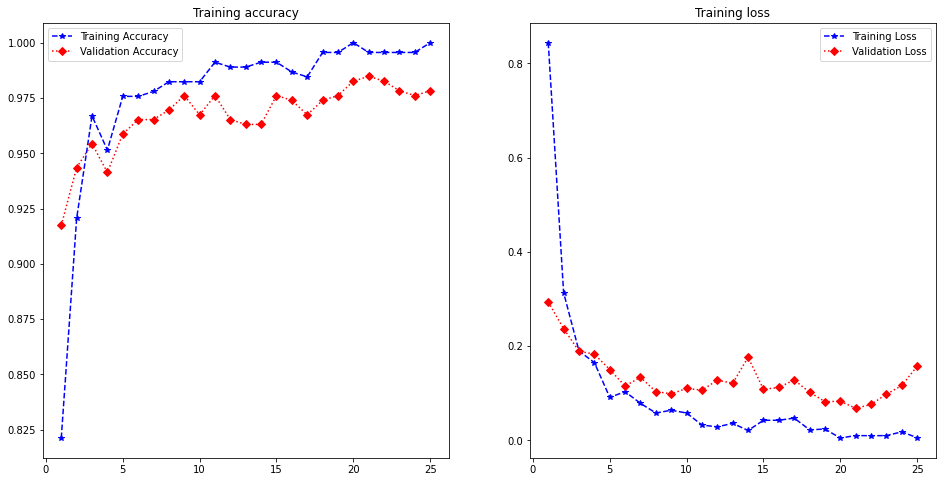

In [28]:
plot_training(history)

In [29]:
new_model = load_model("cnn-wireframes-only.h5")

In [30]:
pred = new_model.predict(
    test_set, 
    steps=test_set.samples//BATCH_SIZE + 1,
    verbose=1
)
pred = np.argmax(pred, axis=1)

47/47 [==============================] - 4s 91ms/step


In [31]:
class_labels = [x[0][x[0].find("/", 10)+1:] for x in os.walk("dataset/snipped")][1:]
class_labels.sort()

Confusion Matrix


Text(0.5, 122.09375, 'Predicted label')

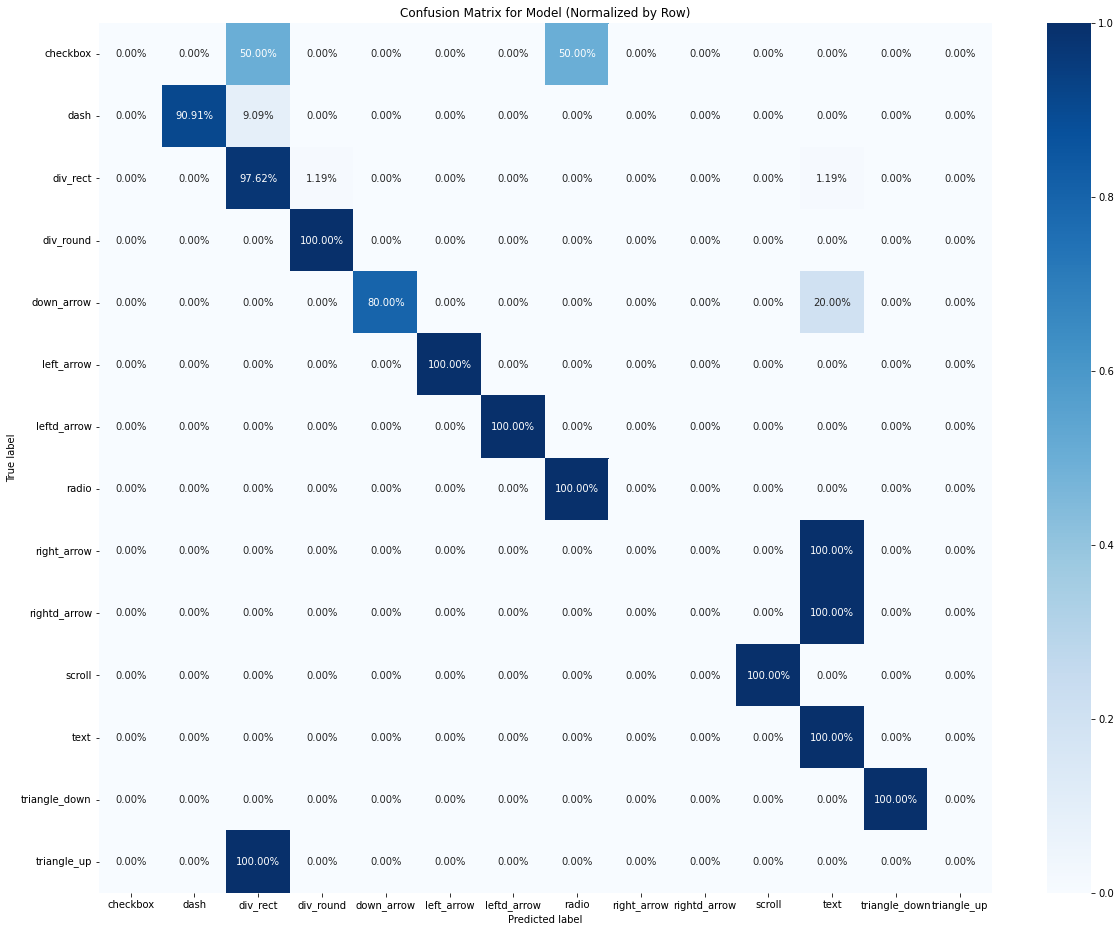

In [32]:
import sklearn

print('Confusion Matrix')
cf = confusion_matrix(test_set.classes[test_set.index_array], pred)

plt.figure(figsize=(20, 16))
normalized_cf = sklearn.preprocessing.normalize(cf, norm="l1")
sns.heatmap(normalized_cf, annot=True, fmt=".2%", xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title("Confusion Matrix for Model (Normalized by Row)")
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [33]:
print('\nClassification Report')
print(classification_report(test_set.classes[test_set.index_array], pred, target_names=class_labels))


Classification Report
               precision    recall  f1-score   support

     checkbox       0.00      0.00      0.00         2
         dash       1.00      0.91      0.95        11
     div_rect       0.98      0.98      0.98       168
    div_round       0.92      1.00      0.96        23
   down_arrow       1.00      0.80      0.89         5
   left_arrow       1.00      1.00      1.00         1
  leftd_arrow       1.00      1.00      1.00         1
        radio       0.89      1.00      0.94         8
  right_arrow       0.00      0.00      0.00         1
 rightd_arrow       0.00      0.00      0.00         1
       scroll       1.00      1.00      1.00         1
         text       0.98      1.00      0.99       226
triangle_down       1.00      1.00      1.00        14
  triangle_up       0.00      0.00      0.00         1

     accuracy                           0.98       463
    macro avg       0.70      0.69      0.69       463
 weighted avg       0.97      0.98      

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    # x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]

In [35]:
# Image preprocessing for robustness
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=(0.9,1),
    height_shift_range=(-0.05, 0.05),
    width_shift_range=(-0.05, 0.05),
)

In [36]:
BATCH_SIZE = 10

print("[INFO] loading images...")
train_data_dir = "./dataset/snipped"     # directory of training data

training_set = train_datagen.flow_from_directory(train_data_dir, 
                                                 target_size=(WIDTH, HEIGHT),
                                                 batch_size=BATCH_SIZE, 
                                                 class_mode='categorical')

[INFO] loading images...
Found 463 images belonging to 14 classes.


In [37]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_data_dir = "./dataset/snipped_generalized"       # directory of test data
test_set = test_datagen.flow_from_directory(test_data_dir, 
                                            target_size=(WIDTH, HEIGHT),
                                            batch_size=BATCH_SIZE, 
                                            class_mode='categorical',
                                            shuffle=False)

Found 1212 images belonging to 13 classes.


In [39]:
pred = new_model.predict(
    test_set, 
    steps=test_set.samples//BATCH_SIZE + 1,
    verbose=1
)
pred = np.argmax(pred, axis=1)

122/122 [==============================] - 13s 107ms/step


In [40]:
class_labels = [x[0][x[0].find("/", 10)+1:] for x in os.walk("dataset/snipped_generalized")][1:]
class_labels.sort()

Confusion Matrix


Text(0.5, 122.09375, 'Predicted label')

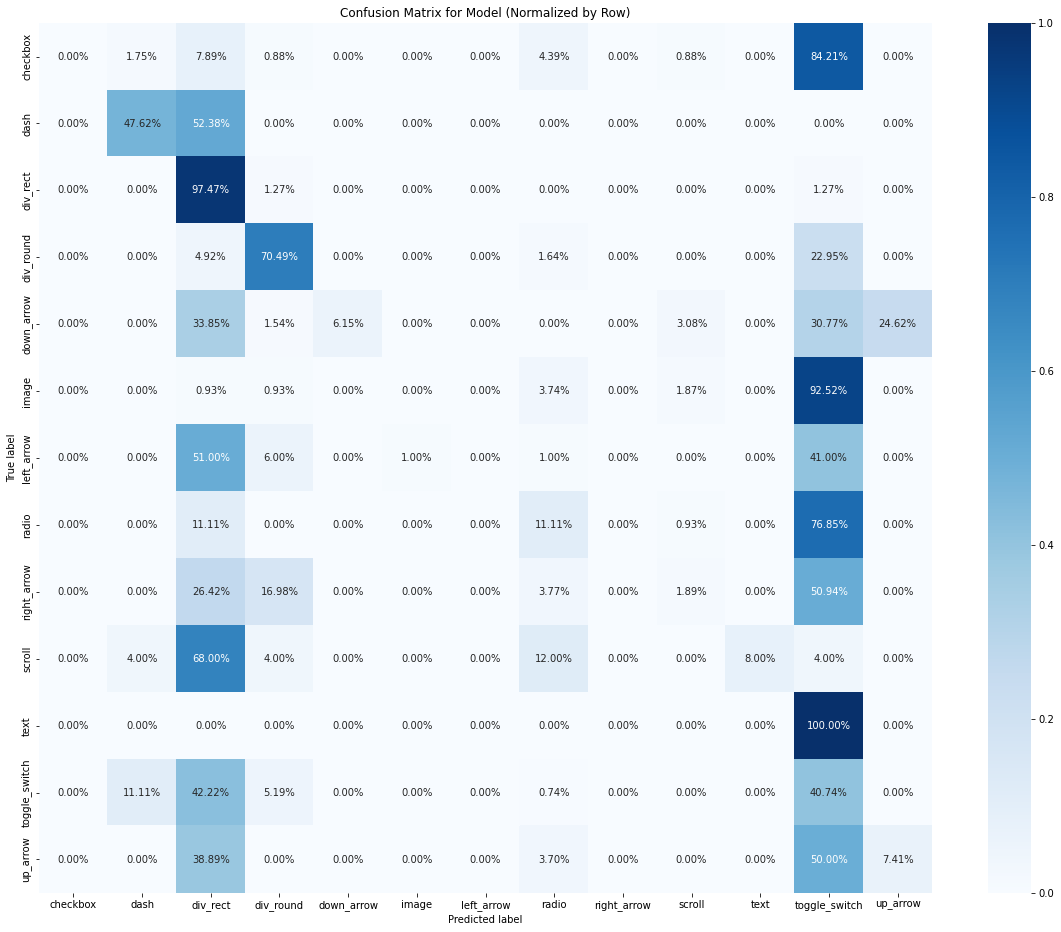

In [41]:
import sklearn

print('Confusion Matrix')
cf = confusion_matrix(test_set.classes[test_set.index_array], pred)

plt.figure(figsize=(20, 16))
normalized_cf = sklearn.preprocessing.normalize(cf, norm="l1")
sns.heatmap(normalized_cf, annot=True, fmt=".2%", xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title("Confusion Matrix for Model (Normalized by Row)")
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [42]:
print('\nClassification Report')
print(classification_report(test_set.classes[test_set.index_array], pred, target_names=class_labels))


Classification Report
               precision    recall  f1-score   support

     checkbox       0.00      0.00      0.00       114
         dash       0.36      0.48      0.41        21
     div_rect       0.41      0.97      0.58       158
    div_round       0.61      0.70      0.65        61
   down_arrow       1.00      0.06      0.12        65
        image       0.00      0.00      0.00       107
   left_arrow       0.00      0.00      0.00       100
        radio       0.39      0.11      0.17       108
  right_arrow       0.00      0.00      0.00        53
       scroll       0.00      0.00      0.00        25
         text       0.00      0.00      0.00       211
toggle_switch       0.08      0.41      0.14       135
     up_arrow       0.20      0.07      0.11        54

     accuracy                           0.23      1212
    macro avg       0.23      0.22      0.17      1212
 weighted avg       0.20      0.23      0.16      1212



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
